In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import pysindy as ps
from tqdm import tqdm
from termcolor import colored
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import yaml

from utils.PolyDiff import PolyDiffPoint
from utils.SeqReg import SeqReg

%matplotlib inline
plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)

In [2]:
class FitEqu(object):
    '''
    Sparse regression to fit a equation

    1. create dataset
    2. preprocess dataset
    3. build library
    4. fit equation
    '''
    def __init__(self):
        super(FitEqu, self).__init__()

    @staticmethod
    def load_dataset(case_id):
        '''
        load dataset
        '''
        U = np.load(f'/mnt/data/dataset/three_cylinder/dataset/euler-equ/{case_id}/u_3D.npy')
        V = np.load(f'/mnt/data/dataset/three_cylinder/dataset/euler-equ/{case_id}/v_3D.npy')
        P = np.load(f'/mnt/data/dataset/three_cylinder/dataset/euler-equ/{case_id}/p_3D.npy')

        P = np.transpose(P, axes=[2, 1, 0])
        U = np.transpose(U, axes=[2, 1, 0])
        V = np.transpose(V, axes=[2, 1, 0])

        return U, V, P
    
    @staticmethod
    def select_sub_domain(U, V, P, x_range, y_range):
        '''
        select a sub-domain
        '''
        # select a sub-domain
        U = U[x_range[0]:x_range[1], y_range[0]:y_range[1], :]
        V = V[x_range[0]:x_range[1], y_range[0]:y_range[1], :]
        P = P[x_range[0]:x_range[1], y_range[0]:y_range[1], :]            
        return U, V, P
        
    @staticmethod
    def add_noise(U, V, P, noise_level=0.01):
        Nx, Ny, Nt = U.shape
        np.random.seed(0)
        U = U + noise_level * np.std(U) * np.random.randn(Nx, Ny, Nt)
        V = V + noise_level * np.std(V) * np.random.randn(Nx, Ny, Nt)
        P = P + noise_level * np.std(P) * np.random.randn(Nx, Ny, Nt)
        return U, V, P
        
    @staticmethod
    def denoise(U, V, P, SVD_mode, is_show=False):
        '''
        SVD denoise
        '''
        Nx, Ny, Nt = U.shape
        U = U.reshape(Nx * Ny, Nt)
        V = V.reshape(Nx * Ny, Nt)
        P = P.reshape(Nx * Ny, Nt)

        uu, sigmau, vu = np.linalg.svd(U, full_matrices=False); vu = vu.T
        uv, sigmav, vv = np.linalg.svd(V, full_matrices=False); vv = vv.T
        up, sigmap, vp = np.linalg.svd(P, full_matrices=False); vp = vp.T

        # singular values of clean data
        if is_show:
            fig = plt.figure()
            plt.semilogy(np.arange(Nt), sigmau, 'g', label = r'$u$')
            plt.semilogy(np.arange(Nt), sigmav, 'b', label = r'$v$')
            plt.semilogy(np.arange(Nt), sigmap, 'r', label = r'$p$')

            plt.legend(loc = 'upper right', fontsize = 20)
            plt.xticks(fontsize = 16)
            plt.yticks(fontsize = 16)
            plt.xlim([0, 30])

        mode_u, mode_v, mode_p = SVD_mode
        U = uu[:,0:mode_u].dot(np.diag(sigmau[0:mode_u]).dot(vu[:,0:mode_u].T)).reshape(Nx, Ny, Nt)
        V = uv[:,0:mode_v].dot(np.diag(sigmav[0:mode_v]).dot(vv[:,0:mode_v].T)).reshape(Nx, Ny, Nt)
        P = up[:,0:mode_p].dot(np.diag(sigmap[0:mode_p]).dot(vp[:,0:mode_p].T)).reshape(Nx, Ny, Nt)

        return U, V, P

    @staticmethod
    def non_dimensionlize(U, V, P, dx, dy, dt, ref_params, sim_params):
        '''
        non-dimensionlize dx, dy, and dt
        '''
        # reference parameters
        l_ref, v_ref, p_ref = ref_params['l_ref'], ref_params['v_ref'], ref_params['p_ref'] 
        t_ref, w_ref = l_ref / v_ref, v_ref / l_ref

        # non-dimensionlize data
        U, V, P = U/v_ref, V/v_ref, P/p_ref
        dx, dy, dt = dx / l_ref, dy / l_ref, dt / t_ref

        # analyze the dimensionless numbers
        Re = v_ref * l_ref * sim_params['rho'] / sim_params['mu']
        Fr = ref_params['v_ref'] / float(np.sqrt(sim_params['g'] * ref_params['l_ref']))
        Eu = ref_params['p_ref'] / (sim_params['rho'] * ref_params['v_ref']**2)
        pi_group = {'Re': Re, 'Fr': Fr, 'Eu': Eu}
        print(colored(f'Re: {int(Re)}, coef_best: {round(1 / Re, 6)}', 'red'))
        print(colored(f'Eu: {int(Eu)}, coef_best: {round(Eu, 6)}', 'red'))
        # print(colored(f'Fr: {int(Fr)}, coef_best: {round(1/Fr/Fr, 6)}', 'red'))
        return U, V, P, dx, dy, dt, pi_group

    @staticmethod
    def sample_points(Nx, Ny, boundary_x, boundary_y, boundary_t):
        '''
        sample a certain number of points to train
        '''
        np.random.seed(0)
        points, count = {}, 0

        num_xy = 500
        for _ in range(num_xy):
            x = np.random.choice(np.arange(boundary_x, Nx-boundary_x), 1)[0]
            y = np.random.choice(np.arange(boundary_y, Ny-boundary_y), 1)[0]
            for t in range(10, 100, 10):
                points[count] = [x, y, t]
                count = count + 1
        return points

    @staticmethod
    def cal_derivatives(U, V, P, points, boundary_x, boundary_y, boundary_t, dx, dy, dt, deg=5):
        num_points = len(points)
        p = np.zeros((num_points,1))
        u = np.zeros((num_points,1))
        v = np.zeros((num_points,1))
        ut, vt = np.zeros((num_points,1)), np.zeros((num_points,1))
        ux, vx = np.zeros((num_points,1)), np.zeros((num_points,1))
        uy, vy = np.zeros((num_points,1)), np.zeros((num_points,1))
        uxx, vxx = np.zeros((num_points,1)), np.zeros((num_points,1))
        uxy, vxy = np.zeros((num_points,1)), np.zeros((num_points,1))
        uyy, vyy = np.zeros((num_points,1)), np.zeros((num_points,1))
        px, py = np.zeros((num_points,1)), np.zeros((num_points,1))

        Nx_sample, Ny_sample, Nt_sample = 2*boundary_x-1, 2*boundary_y-1, 2*boundary_t-1

        for idx_p in tqdm(points.keys()):
            [x, y, t] = points[idx_p]
            u[idx_p] = U[x, y, t]
            v[idx_p] = V[x, y, t]
            p[idx_p] = P[x, y, t]
            
            ut_part = U[x, y, t-int((Nt_sample-1)/2):t+int((Nt_sample+1)/2)]
            ux_part = U[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y, t]
            uy_part = U[x, y-int((Ny_sample-1)/2):y+int((Ny_sample+1)/2), t]
            ux_part_yp = U[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y+1, t]
            ux_part_ym = U[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y-1, t]

            vt_part = V[x, y, t-int((Nt_sample-1)/2):t+int((Nt_sample+1)/2)]
            vx_part = V[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y, t]
            vy_part = V[x, y-int((Ny_sample-1)/2):y+int((Ny_sample+1)/2), t]
            vx_part_yp = V[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y+1, t]
            vx_part_ym = V[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y-1, t]

            px_part = P[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y, t]
            py_part = P[x, y-int((Ny_sample-1)/2):y+int((Ny_sample+1)/2), t]

            ut[idx_p] = PolyDiffPoint(ut_part, np.arange(Nt_sample)*dt, deg, 1)[0]
            ux_diff = PolyDiffPoint(ux_part, np.arange(Nx_sample)*dx, deg, 2)
            uy_diff = PolyDiffPoint(uy_part, np.arange(Ny_sample)*dy, deg, 2)
            ux_diff_yp = PolyDiffPoint(ux_part_yp, np.arange(Nx_sample)*dx, deg, 2)
            ux_diff_ym = PolyDiffPoint(ux_part_ym, np.arange(Nx_sample)*dx, deg, 2)

            vt[idx_p] = PolyDiffPoint(vt_part, np.arange(Nt_sample)*dt, deg, 1)[0]
            vx_diff = PolyDiffPoint(vx_part, np.arange(Nx_sample)*dx, deg, 2)
            vy_diff = PolyDiffPoint(vy_part, np.arange(Ny_sample)*dy, deg, 2)
            vx_diff_yp = PolyDiffPoint(vx_part_yp, np.arange(Nx_sample)*dx, deg, 2)
            vx_diff_ym = PolyDiffPoint(vx_part_ym, np.arange(Nx_sample)*dx, deg, 2)

            ux[idx_p], uxx[idx_p] = ux_diff[0], ux_diff[1]
            uy[idx_p], uyy[idx_p] = uy_diff[0], uy_diff[1]
            uxy[idx_p] = (ux_diff_yp[0] - ux_diff_ym[0]) / (2 * dy)

            vx[idx_p], vxx[idx_p] = vx_diff[0], vx_diff[1]
            vy[idx_p], vyy[idx_p] = vy_diff[0], vy_diff[1]
            vxy[idx_p] = (vx_diff_yp[0] - vx_diff_ym[0]) / (2 * dy)

            px[idx_p] = PolyDiffPoint(px_part, np.arange(Nx_sample)*dx, deg, 1)[0]
            py[idx_p] = PolyDiffPoint(py_part, np.arange(Ny_sample)*dy, deg, 1)[0]
        
        base_library = [u, v, p, ut, ux, uy, uxx, uxy, uyy, vt, vx, vy, vxx, vxy, vyy, px, py]
        return base_library

    @staticmethod
    def parse_library(base_library, sim_params, ref_params):
        '''
        calculate derivatives and build library for sparse regression
        '''
        u, v, p, ut, ux, uy, uxx, uxy, uyy, vt, vx, vy, vxx, vxy, vyy, px, py = base_library
        g_x = np.zeros_like(u)
        g_y = np.ones_like(u) * sim_params['g'] * ref_params['l_ref'] / ref_params['v_ref']**2
        # ########################standard sindy library#########################
        # X_library = [u*ux, v*uy, uxx, uyy, px]
        # names = ['u*ux', 'v*uy', 'uxx', 'uyy', 'px']

        # #########################rotationial invariance#########################
        ########################## More terms (6 terms in total, 4 independent terms)##########################
        ut_ = np.concatenate([ut+vt, vt+ut])
        u_ = np.concatenate([u+v, v+u])
        uu_ = np.concatenate([u*(u+v), v*(v+u)])
        vu_ = np.concatenate([v*(u+v), u*(v+u)])

        ux_ = np.concatenate([ux+vx, vy+uy])
        uy_ = np.concatenate([uy+vy, vx+ux])
        uxx_ = np.concatenate([uxx+vxx, vyy+uyy])
        uyy_ = np.concatenate([uyy+vyy, vxx+uxx])

        uux_ = np.concatenate([u*(ux+vx), v*(vy+uy)])
        uuy_ = np.concatenate([u*(uy+vy), v*(vx+ux)])
        uuxx_ = np.concatenate([u*(uxx+vxx), v*(vyy+vyy)])
        uuyy_ = np.concatenate([u*(uyy+vyy), v*(vxx+uxx)])

        vux_ = np.concatenate([v*(ux+vx), u*(vy+uy)])
        vuy_ = np.concatenate([v*(uy+vy), u*(vx+ux)])
        vuxx_ = np.concatenate([v*(uxx+vxx), u*(vyy+vyy)])
        vuyy_ = np.concatenate([v*(uyy+vyy), u*(vxx+uxx)])

        uuxx_ = np.concatenate([u*(uxx+vxx), v*(vyy+vyy)])
        uuyy_ = np.concatenate([u*(uyy+vyy), v*(vxx+uxx)])
        vuxx_ = np.concatenate([v*(uxx+vxx), u*(vyy+vyy)])
        vuyy_ = np.concatenate([v*(uyy+vyy), u*(vxx+uxx)])
        
        p_ = np.concatenate([p, p])
        px_ = np.concatenate([px+py, py+px])

        ut, u, uu, vu, ux, uy, uxx, uyy = ut_, u_, uu_, vu_, ux_, uy_, uxx_, uyy_
        uux, uuy, uuxx, uuyy, vux, vuy, vuxx, vuyy, px = uux_, uuy_, uuxx_, uuyy_, vux_, vuy_, vuxx_, vuyy_, px_
        p = p_

        # term and position: (uux: 7, vuy: 12, uxx: 5, uyy: 6, px: 16)
        X_library = [
            u, uu, vu, ux, uy, 
            uxx, uyy, uux, uuy, uuxx, 
            uuyy, vux, vuy, vuxx, vuyy, 
            p, px]
        names = ['u', 'uu', 'vu', 'ux', 'uy', 'uxx', 'uyy', 'uux', 
                'uuy', 'uuxx', 'uuyy', 'vux', 'vuy', 'vuxx', 'vuyy', 'p', 'px']
        
        ##########################Reshape data##########################
        X_library = np.squeeze(np.stack(X_library, axis=-1))
        y_library = ut.reshape(-1, 1)

        return X_library, y_library, names

    @staticmethod
    def normalization(X_library, y_library):
        '''
        Rescale the data by each column
        rescale the data by the absolute mean for each column
        '''
        norm_coef = np.mean(np.abs(np.mean(X_library, axis=0)))
        X_library = X_library / norm_coef
        y_library = y_library / norm_coef
        return X_library, y_library, norm_coef

    @staticmethod
    def check_library(X_library, y_library):
        '''
        check whether the library has any Nan
        '''
        if np.any(np.isnan(X_library)) or np.any(np.isnan(y_library)):
            print('Nan exists in library.')
            return True
        return False

    @staticmethod
    def check_equ(X_library, y_library, pi_group):
        '''
        check the r2 for the target equation
        '''
        pred_best = - X_library[:, 7] - X_library[:, 12]\
                    + 1/pi_group['Re'] * (X_library[:, 5] + X_library[:, 6]) \
                    - X_library[:, 16] * pi_group['Eu']
        pred_best = pred_best.reshape(-1,1)
        r2 = r2_score(y_library, pred_best)
        print(f"Analytical r2_score: {round(r2, 6)}")

        pred_best = - X_library[:, 7] - X_library[:, 12]\
                    - X_library[:, 16] * pi_group['Eu']
        pred_best = pred_best.reshape(-1,1)
        r2_2 = r2_score(y_library, pred_best)
        print(f"Analytical r2_score (no 1/Re): {round(r2_2, 6)}")
        print('difference', r2-r2_2)
        return None
        
    @staticmethod
    def fit(X_library, y_library, threshold=0.002):
        '''
        squential threshold with dynamic threshold
        '''
        model = SeqReg()
        coef, _, r2 = model.fit_dynamic_thresh(X_library, y_library, 
                        is_normalize=False, non_zero_term=3, threshold=threshold, fit_intercept=False, model_name='LR')
        print('Fitting r2', r2)
        return coef


**************************************** v2-Re-100
Re: 100, coef_best: 0.01
Eu: 14545, coef_best: 14545.454545


100%|██████████| 4500/4500 [00:12<00:00, 356.29it/s]


Analytical r2_score: 0.997101
Analytical r2_score (no 1/Re): 0.989197
difference 0.007904590082470353
Fitting r2 0.9919349449653408
coef_res: [('px', -14015.250654), ('uux', -1.036132), ('vuy', -1.036132)]
**************************************** v1-Re-170
Re: 170, coef_best: 0.005882
Eu: 3897, coef_best: 3897.626183


100%|██████████| 4500/4500 [00:12<00:00, 353.51it/s]


Analytical r2_score: 0.993806
Analytical r2_score (no 1/Re): 0.991886
difference 0.0019202931978206106
Fitting r2 0.9919227024826537
coef_res: [('px', -3873.863307), ('uux', -0.994643), ('vuy', -0.994643)]
**************************************** v3-Re-200
Re: 200, coef_best: 0.005
Eu: 3019, coef_best: 3019.973003


100%|██████████| 4500/4500 [00:13<00:00, 329.06it/s]


Analytical r2_score: 0.972686
Analytical r2_score (no 1/Re): 0.970038
difference 0.0026478249473042004
Fitting r2 0.9704769649468544
coef_res: [('px', -2953.947067), ('uux', -1.008893), ('vuy', -1.008893)]


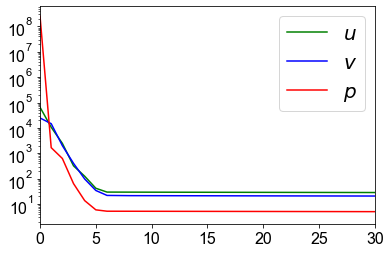

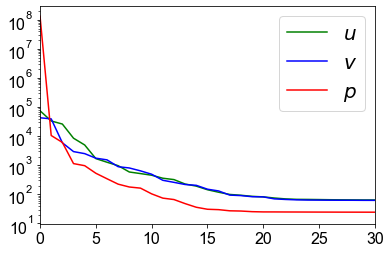

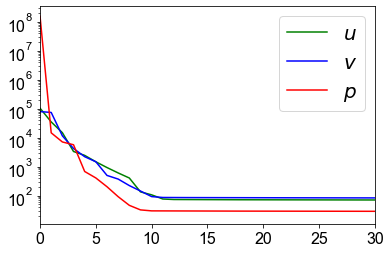

In [3]:
config_path = 'configs/config_Euler_3cylinder_noise.yml'
config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
case_id_list = list(config['case_id_list'].keys())

def prepare_dataset(is_show=False):
    '''
    prepare a sets of dataset
    '''
    res = []
    fit_equ = FitEqu()

    for case_id in case_id_list:
        print('*' * 40, case_id)
        case_info = config['case_id_list'][case_id]
        Nx, Ny = 500, 222
        dx, dy = 0.9/Nx, 0.4/Ny

        ref_params = case_info['ref_params']
        sim_params = case_info['sim_params']
        sim_params['niu'] = sim_params['mu'] / sim_params['rho']
        dt = sim_params['dt']

        # parameters for sparse regression
        x_range, y_range = case_info['x_range'], case_info['y_range']
        boundary_x, boundary_y, boundary_t = case_info['fitting']['boundary_num']  # default is 5
        deg = case_info['fitting']['deg']               # polynomial degree default is 3
        
        #####################Prepare Dataset#####################
        # generate data and save to a folder
        U, V, P = fit_equ.load_dataset(case_id)
        U, V, P = fit_equ.select_sub_domain(U, V, P, x_range, y_range)
        U, V, P = fit_equ.add_noise(U, V, P, noise_level=0.01)
        U, V, P = fit_equ.denoise(U, V, P, case_info['SVD_mode'], is_show=True)
        # non-dimensionlize data and dx, dy, dt
        U, V, P, dx, dy, dt, pi_group = fit_equ.non_dimensionlize(U, V, P, dx, dy, dt, ref_params, sim_params)
        Nx, Ny, Nt = P.shape
        # sample points
        points = fit_equ.sample_points(Nx, Ny, boundary_x, boundary_y, boundary_t)        
        # plot the 1st frame 
        if is_show: fig = plt.figure(figsize=(6, 4)); plt.imshow(V[:, :, 0].T)
        
        #####################Prepare library#####################
        base_library = fit_equ.cal_derivatives(
            U, V, P, points, boundary_x, boundary_y, boundary_t, dx, dy, dt, deg)
        X_library, y_library, names = fit_equ.parse_library(base_library, sim_params, ref_params)
        X_library, y_library, norm_coef = fit_equ.normalization(X_library, y_library)
        # check data
        is_nan = fit_equ.check_library(X_library, y_library)
        if is_nan: continue
        df_all = pd.DataFrame(np.concatenate([X_library, y_library], axis=1))
        # check the fitting of the target equation
        fit_equ.check_equ(X_library, y_library, pi_group)
        # visualization library
        # if is_show: fig = plt.figure(); df_all.plot(); plt.xlim([0, 2000])

        #####################Fit sequential sparse regression#####################
        coef = fit_equ.fit(X_library, y_library)
        # coef = np.multiply(norm_coef, coef)
        # print('rescale coef', coef)
        coef_res = [(each[0], round(each[1], 6)) for each in list(zip(names, coef.tolist())) if abs(each[1]) > 1e-3]
        coef_res = sorted(coef_res, key=lambda x: abs(x[1]), reverse=True)
        print(colored(f'coef_res: {coef_res}', 'red'))
        # add to the total results
        res.append([sim_params['niu'], ref_params['l_ref'], ref_params['v_ref'], ref_params['p_ref'],
                sim_params['rho'], sim_params['g'], pi_group['Re'], pi_group['Eu'], pi_group['Fr']] + coef.tolist())
        
    df = pd.DataFrame(res)
    return df


df = prepare_dataset()
df.to_csv('../dataset/dataset_NS_flow3D.csv')

In [4]:
df = pd.read_csv('../dataset/dataset_NS_flow3D.csv')
df = df.rename(columns={
    '0': 'nu',
    '1': 'diameter',
    '2': 'v_init',
    '3': 'p_init',
    '4': 'density',
    '5': 'g',
    '6': 'Re',
    '7': 'Eu',
    '8': 'Fr',
    })
df['mu'] = df['nu'] * df['density']
df['1/Re'] = 1/ df['Re']
# print(df.head())
df.to_csv('../dataset/dataset_NS_flow3D.csv')

In [5]:
df[['Eu', '25', '21']]

,Eu,25,21
0,14545.454545,-14015.250654,-1.036132
1,3897.626183,-3873.863307,-0.994643
2,3019.973003,-2953.947067,-1.008893


In [6]:
r2_score(df['1/Re'], df['14'])

-10.203738348681851

In [7]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_coef, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_coef = output_coef
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_coef].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in = self.basis_list[0], self.basis_list[1]
        return basis1_in, basis2_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + coef[1] * self.basis2_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        # print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        # print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def fit_pattern_search(self, seed):
        '''
        pattern search
        '''
        def get_coordinates(a, b, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for a_ in [a-delta, a, a+delta]:
                for b_ in [b-delta, b, b+delta]:
                    if [a_, b_] != [a, b]:
                        coord_all.append([a_, b_])
            return coord_all
        
        def opt(coef):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(pi_in, self.y)
            y_pred = reg.predict(pi_in)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        b = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        # a, b = -1, 0
        coef = np.array([a, b]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 10, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, b, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a, b])
                break
            
            r2_bounds_val = []
            for [a_, b_] in candidate_coord:
                coef_temp = np.array([a_, b_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a, b] = candidate_coord[highest_index]
                coef = np.array([a, b]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'b': b, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef_final, coef_w_final = opt(coef)
        return r2, reg_coef_final, coef_w_final

In [8]:
def recover_coef1(seed):
    input_list = ['mu', 'diameter', 'v_init', 'density', 'p_init']
    output_coef = '25'  # for Eu

    D_in = np.mat('-1, -1, 1; 1, 0, 0; 1, -1, 0; -3, 0, 1; -1, -2, 1').T
    D_out = np.mat('0;, 0; 0')
    dimension_info = [D_in, D_out]

    basis1_in = np.array([-1, 1, 1, 1, 0]).reshape(-1, 1)
    basis2_in = np.array([-1, 1, -1, 0, 1]).reshape(-1, 1)
    basis_list = [basis1_in, basis2_in]
    
    dimensionless_learning = DimensionlessLearning(
        df, input_list, output_coef, dimension_info, basis_list)
    # dimensionless_learning.check_dimension(coef=[-1, 1])

    # pattern search
    r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
    if r2 > 0.8:
        print('final r2', r2, coef.flatten(), coef_w)

for i in range(10):
    recover_coef1(seed=i)

final r2 0.9971524690069125 [-2.5  2.5 -1.5  0.5  2. ] [[-0.]]
final r2 0.9971524690069125 [-2.5  2.5 -1.5  0.5  2. ] [[-0.]]
final r2 0.9998083332497337 [ 0.  0. -2. -1.  1.] [[-0.96606747]]
final r2 0.9998083332497337 [ 0.  0. -2. -1.  1.] [[-0.96606747]]
final r2 0.9998083332497337 [ 0.  0. -2. -1.  1.] [[-0.96606747]]
final r2 0.9998083332497337 [ 0.  0. -2. -1.  1.] [[-0.96606747]]
final r2 0.9971524690069125 [-2.5  2.5 -1.5  0.5  2. ] [[-0.]]
